In [18]:
!nvidia-smi

Thu Aug 31 17:42:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |   4429MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
%pip install -q \
autodistill \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# !pip3 install autodistill-owl-vit
# %pip3 install autodistill-fastsam
%pip install autodistill-grounding-dino
%pip install autodistill-grounded-sam

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
# !mkdir -p "/content/drive/MyDrive/CrownePlaza/frames"
# # !tar -xvzf "/content/drive/MyDrive/CrownePlaza/all.tar.gz" -C "/content/drive/MyDrive/CrownePlaza/frames"
# !unzip -o "/content/drive/MyDrive/CrownePlaza/all.zip" -d "/content/drive/MyDrive/CrownePlaza/frames"

## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

**NOTE:** We can also plot sample of our image dataset.

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [ ]:
from autodistill.detection import CaptionOntology
ontology=CaptionOntology({
  "thing": "thing"
})

In [1]:
from pathlib import Path
HOME = Path.cwd().parent
print(HOME)

/home/ubuntu/graymatics-detections-matt/crown-plaza


### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.empty_cache() 

In [3]:
from autodistill_grounded_sam import GroundedSAM
# from autodistill_owl_vit import OWLViT
# from autodistill_fastsam import FastSAM
from autodistill_grounding_dino import GroundingDINO

/home/ubuntu/anaconda3/envs/matt-yolo-detect/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_model = GroundedSAM(ontology=ontology)
# base_model = GroundingDINO(ontology=ontology)
# base_model = OWLViT(ontology=ontology)
# base_model = FastSAM(ontology=ontology)

NameError: name 'GroundedSAM' is not defined

In [4]:
DATA_HOME = HOME/'data'
IMAGE_DIR_PATH = f"{DATA_HOME}/frames-processed/all"
DATASET_DIR_PATH = f"{DATA_HOME}/dataset-sam-processd"
print(IMAGE_DIR_PATH, DATASET_DIR_PATH, sep='\n')

/home/ubuntu/graymatics-detections-matt/crown-plaza/data/frames-processed/all
/home/ubuntu/graymatics-detections-matt/crown-plaza/data/dataset-sam-processd


image count: 382


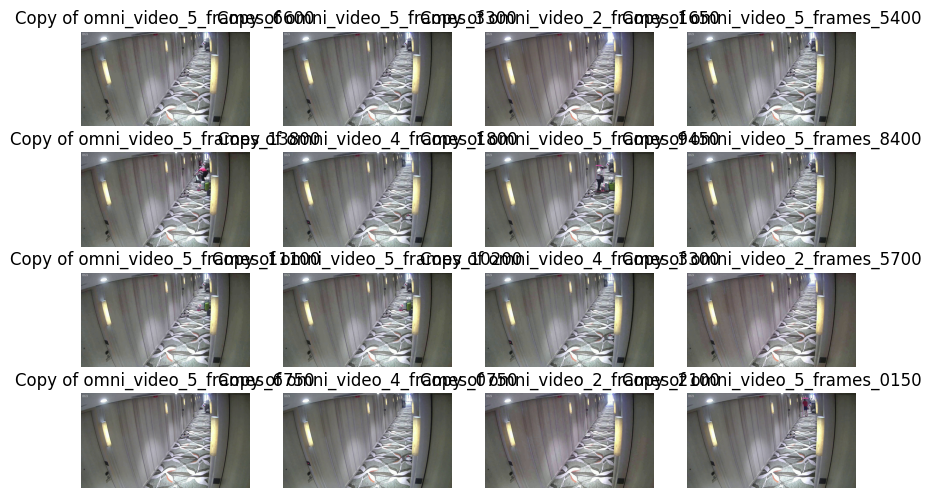

In [ ]:
import cv2
import supervision as sv

SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (10, 6)

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [ ]:
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH
)

Labeling /home/ubuntu/graymatics-detections-matt/crown-plaza/data/frames-processed/all/Copy of omni_video_5_frames_6600.jpg:   0%|          | 0/191 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/matt-yolo-detect/lib/python3.10/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/ubuntu/anaconda3/envs/matt-yolo-detect/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Labeling /home/ubuntu/graymatics-detections-matt/crown-plaza/data/frames-processed/all/Copy of omni_video_5_frames_0000.jpg: 100%|██████████| 191/191 [10:50<00:00,  3.40s/it] 


Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [5]:
ANNOTATIONS_DIRECTORY_PATH = f"{DATASET_DIR_PATH}/train/labels"
IMAGES_DIRECTORY_PATH = f"{DATASET_DIR_PATH}/train/images"
DATA_YAML_PATH = f"{DATASET_DIR_PATH}/data.yaml"

In [6]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

152

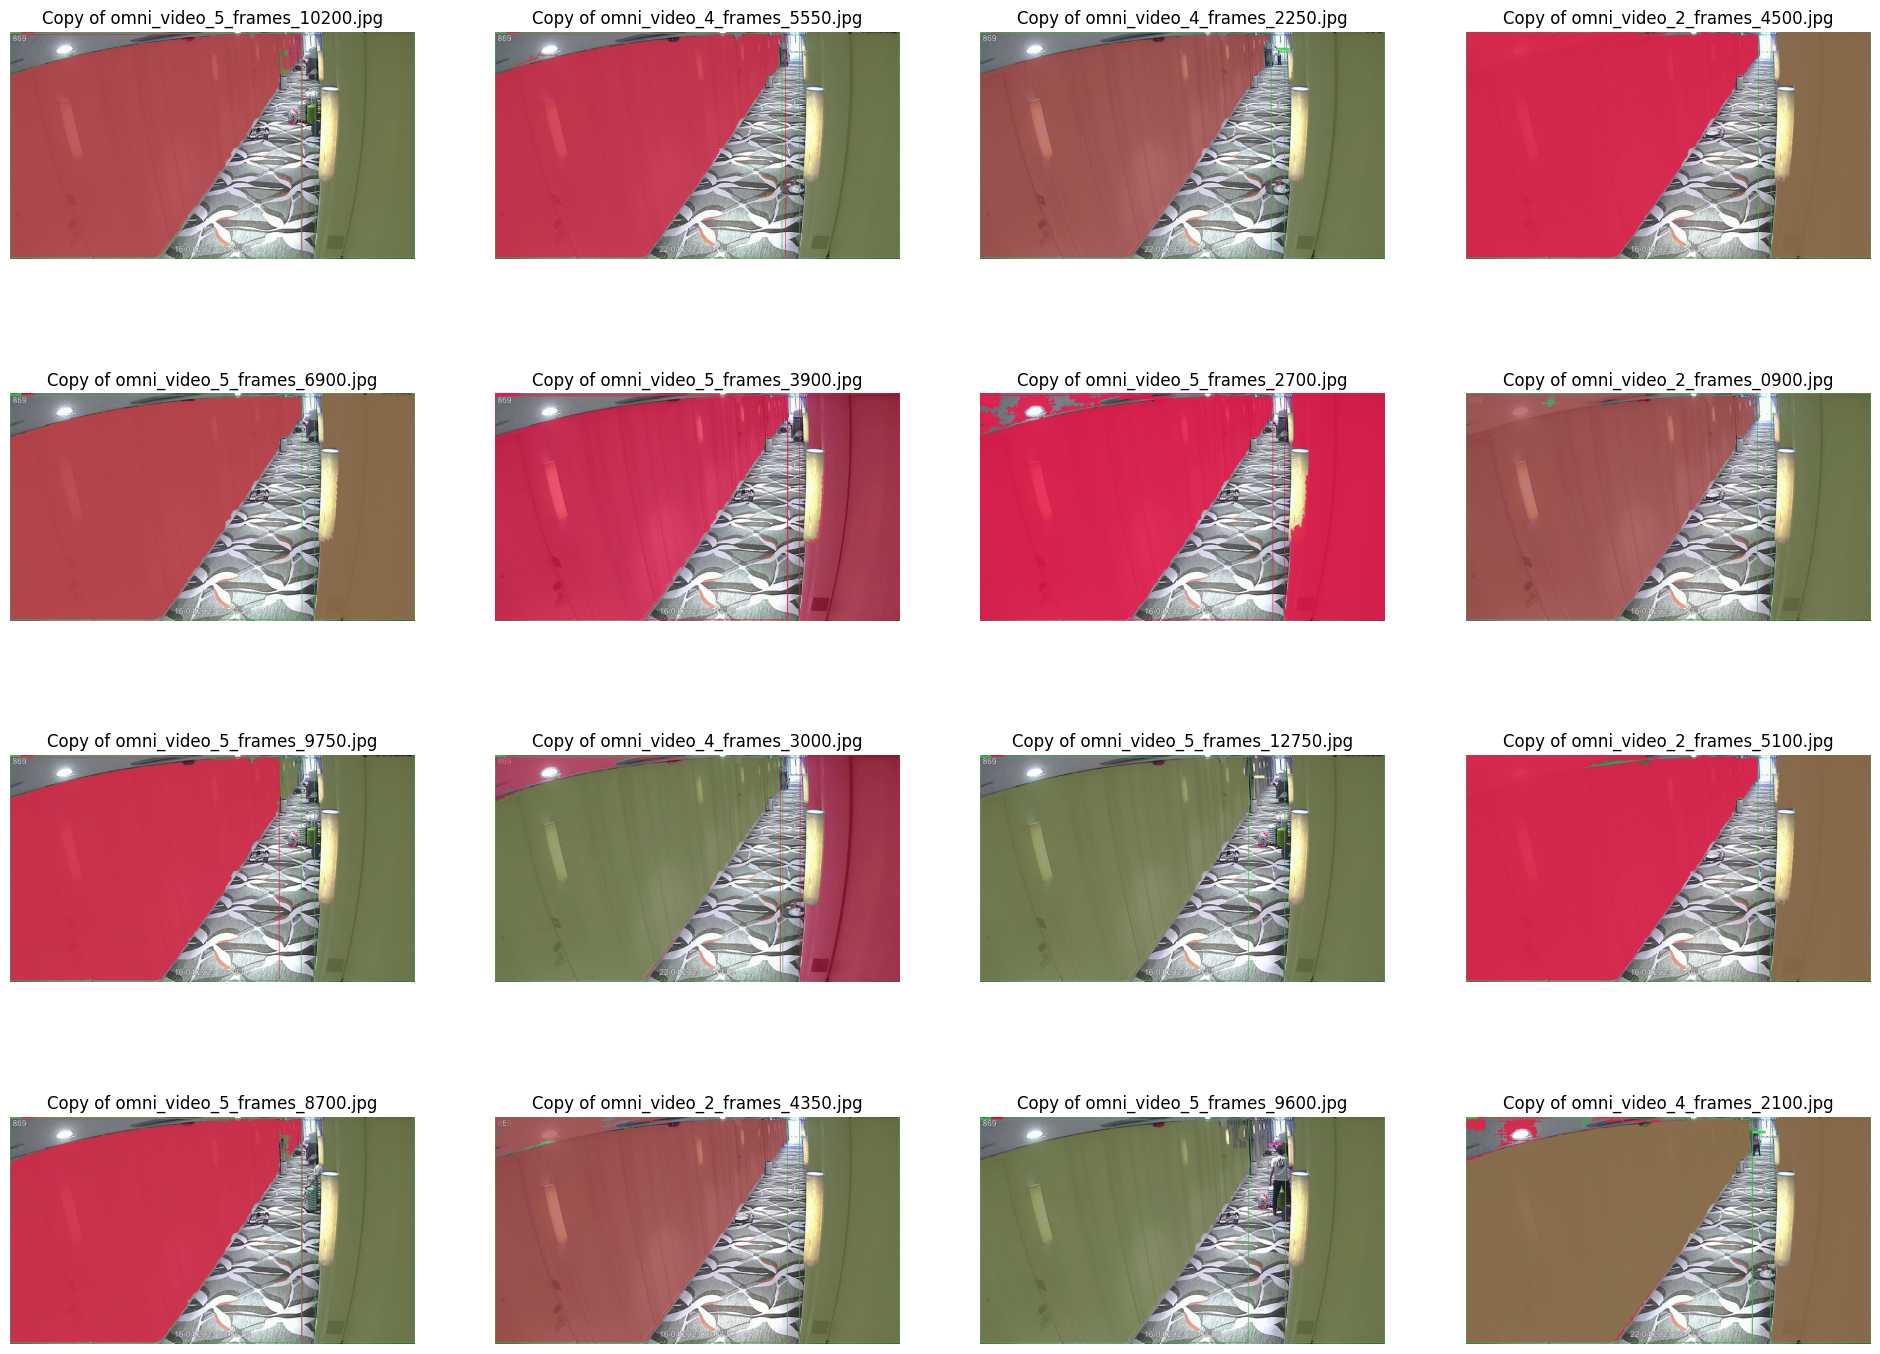

In [ ]:
import supervision as sv

SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (24, 18)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [6]:
dataset_name = 'project-1_omni-processed'
DATA_YAML_PATH = f'{DATA_HOME}/{dataset_name}/data.yaml'
print(DATA_YAML_PATH)

/home/ubuntu/graymatics-detections-matt/crown-plaza/data/project-1_omni-processed/data.yaml


In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

# target_model = YOLOv8("yolov8n.pt")
# chkpt_run = 'train2'
# target_model = YOLOv8(f"{HOME}/runs/detect/{chkpt_run}/weights/best.pt")
target_model.train(DATA_YAML_PATH, epochs=70)

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/home/ubuntu/graymatics-detections-matt/crown-plaza


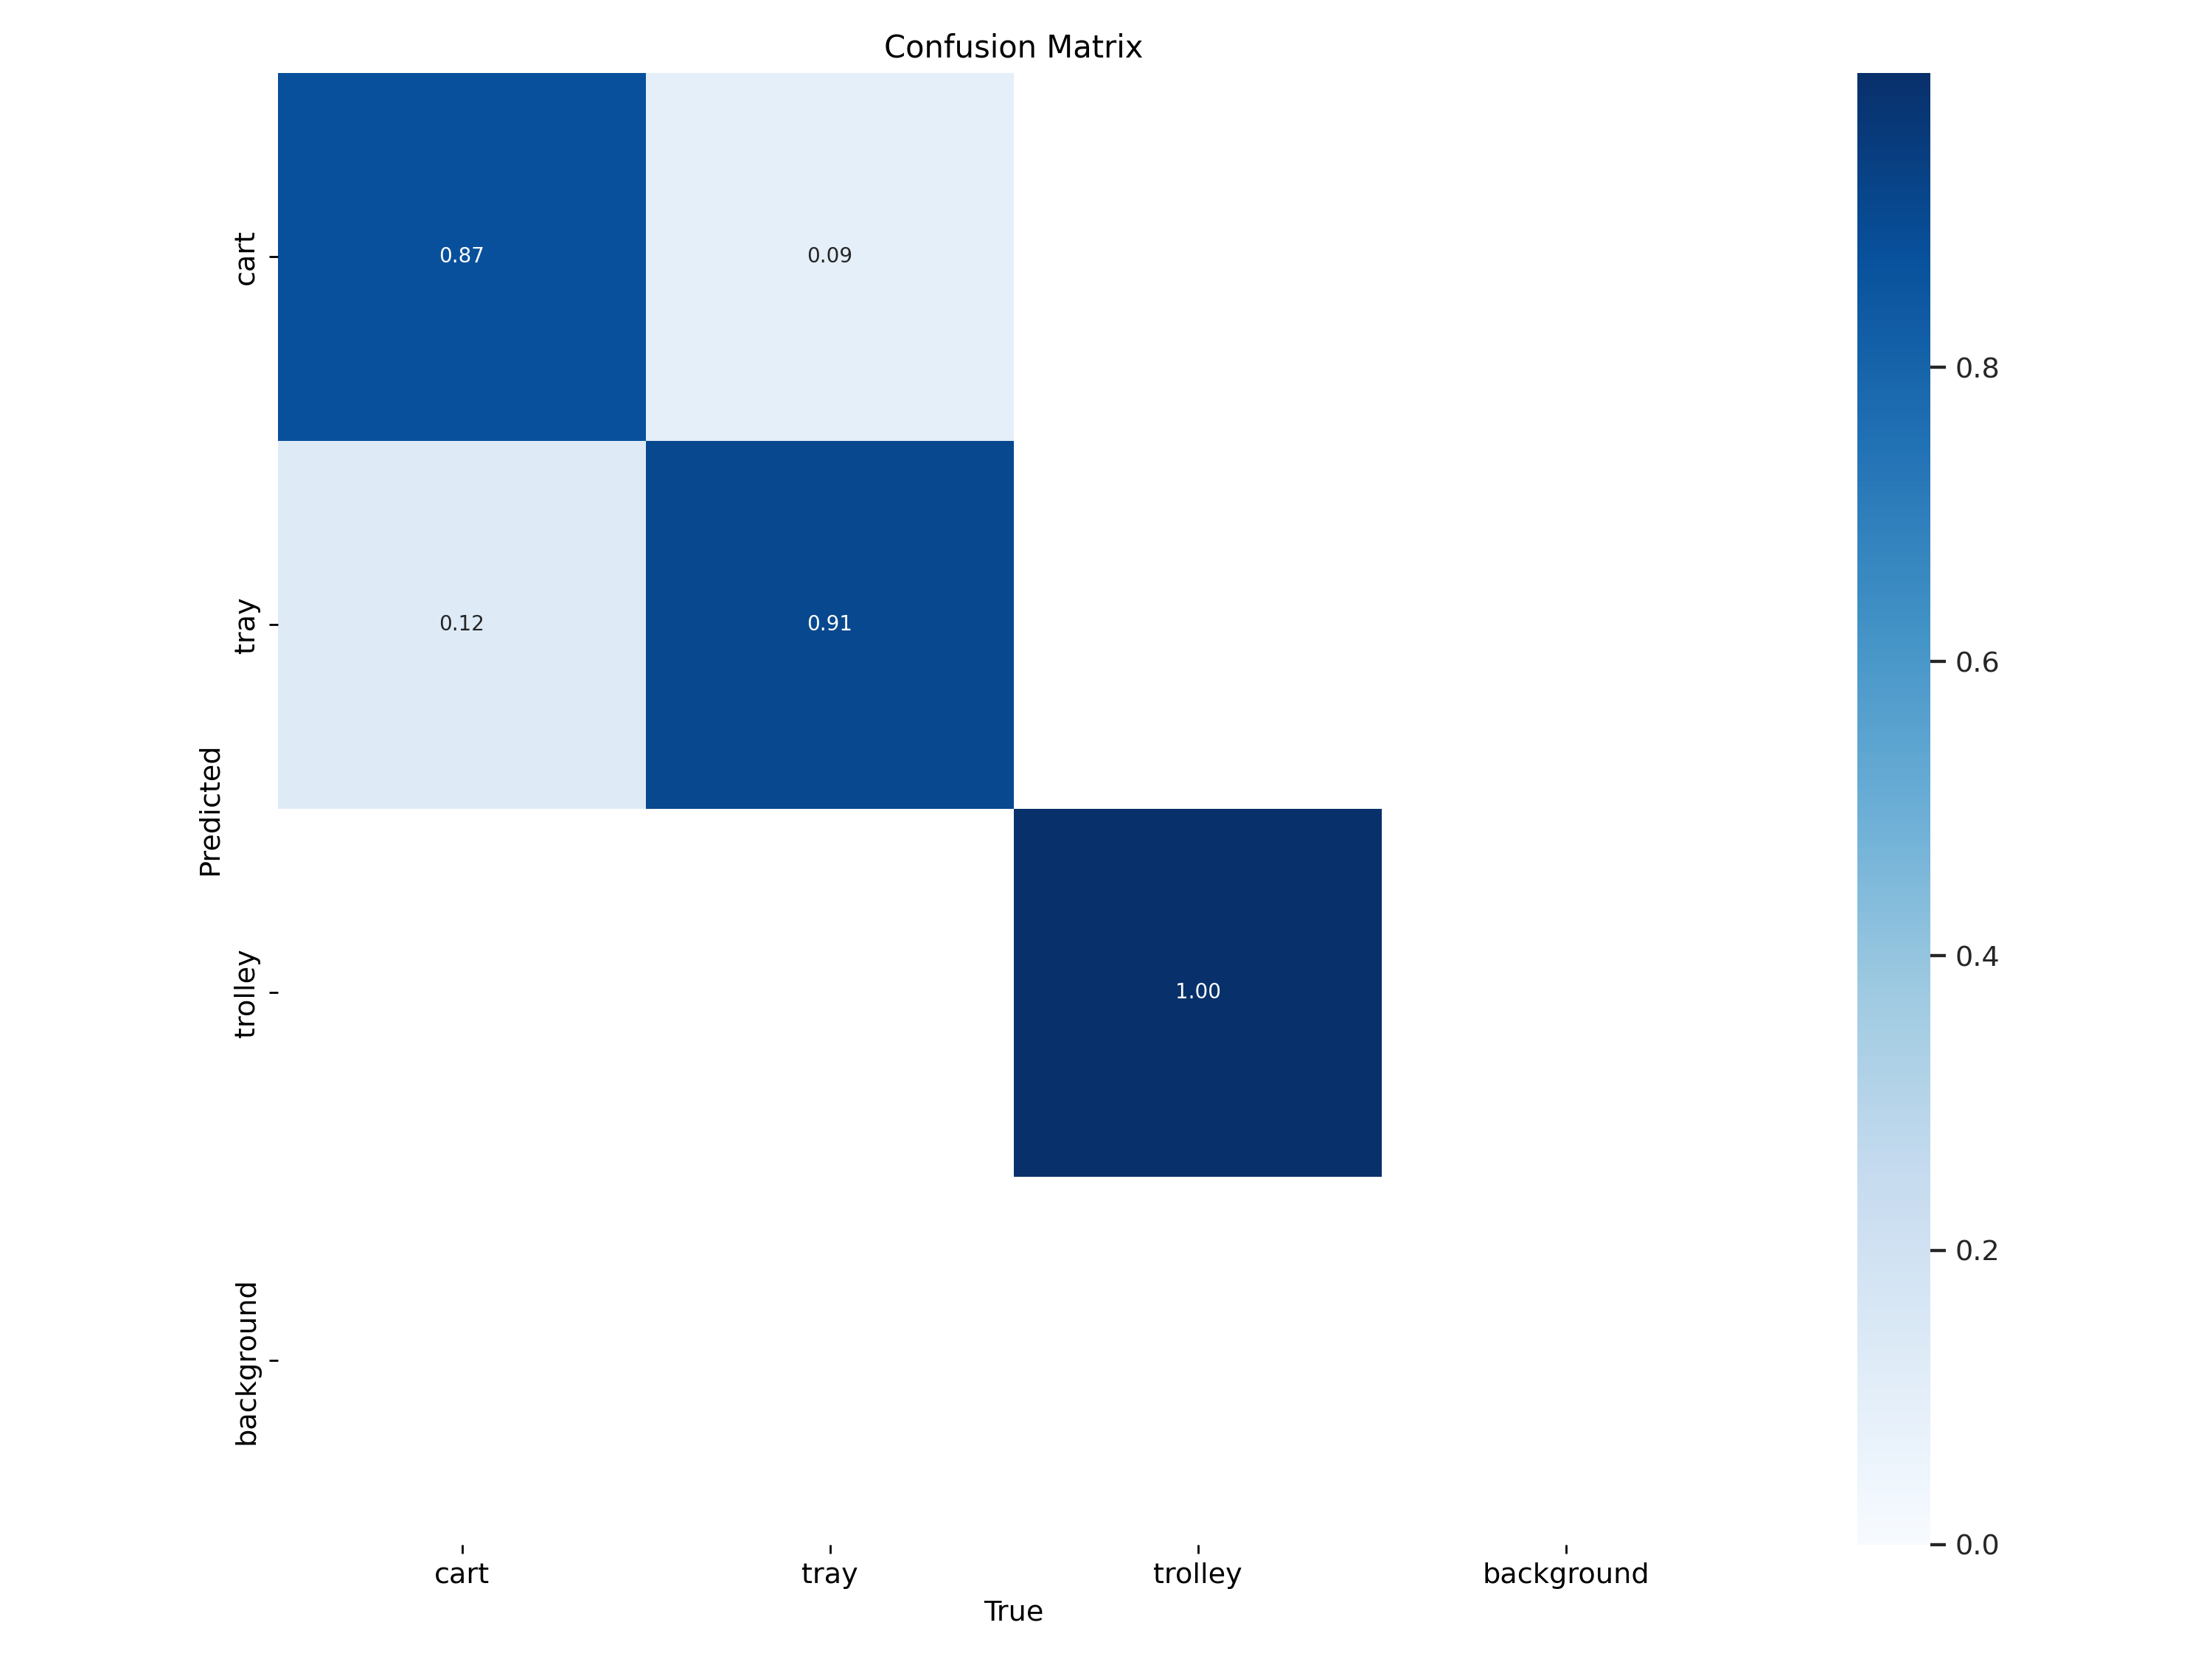

In [6]:
%cd {HOME}

from IPython.display import Image
run_name = 'train3'
Image(filename=f'{HOME}/runs/detect/{run_name}/confusion_matrix.png', width=600)

/home/ubuntu/graymatics-detections-matt/crown-plaza


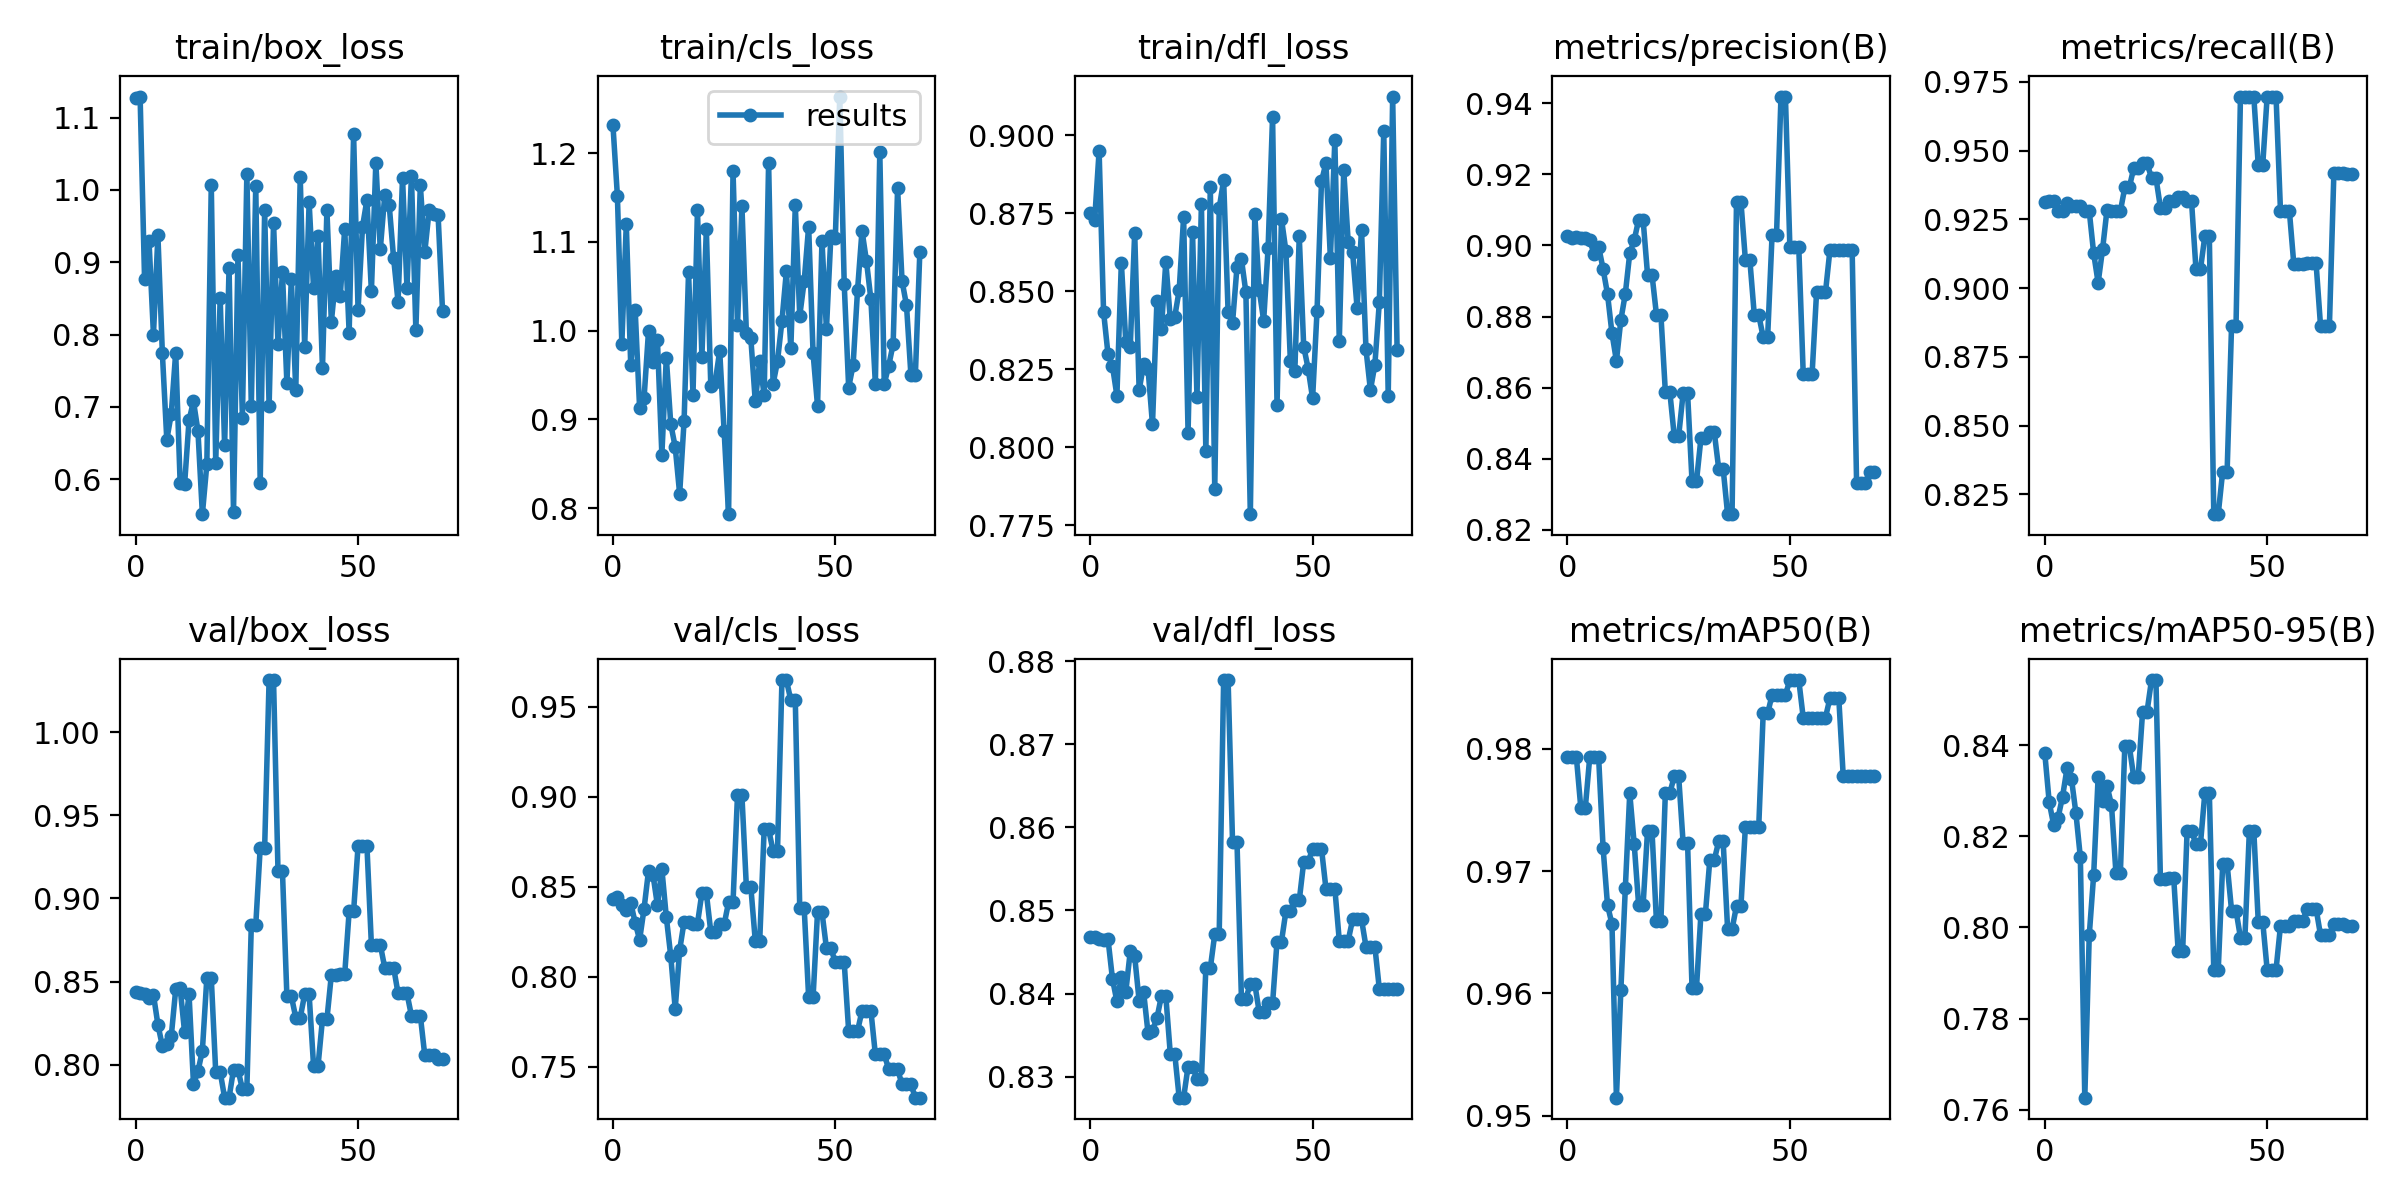

In [7]:
%cd {HOME}

from IPython.display import Image
Image(filename=f'{HOME}/runs/detect/{run_name}/results.png', width=600)

/home/ubuntu/graymatics-detections-matt/crown-plaza


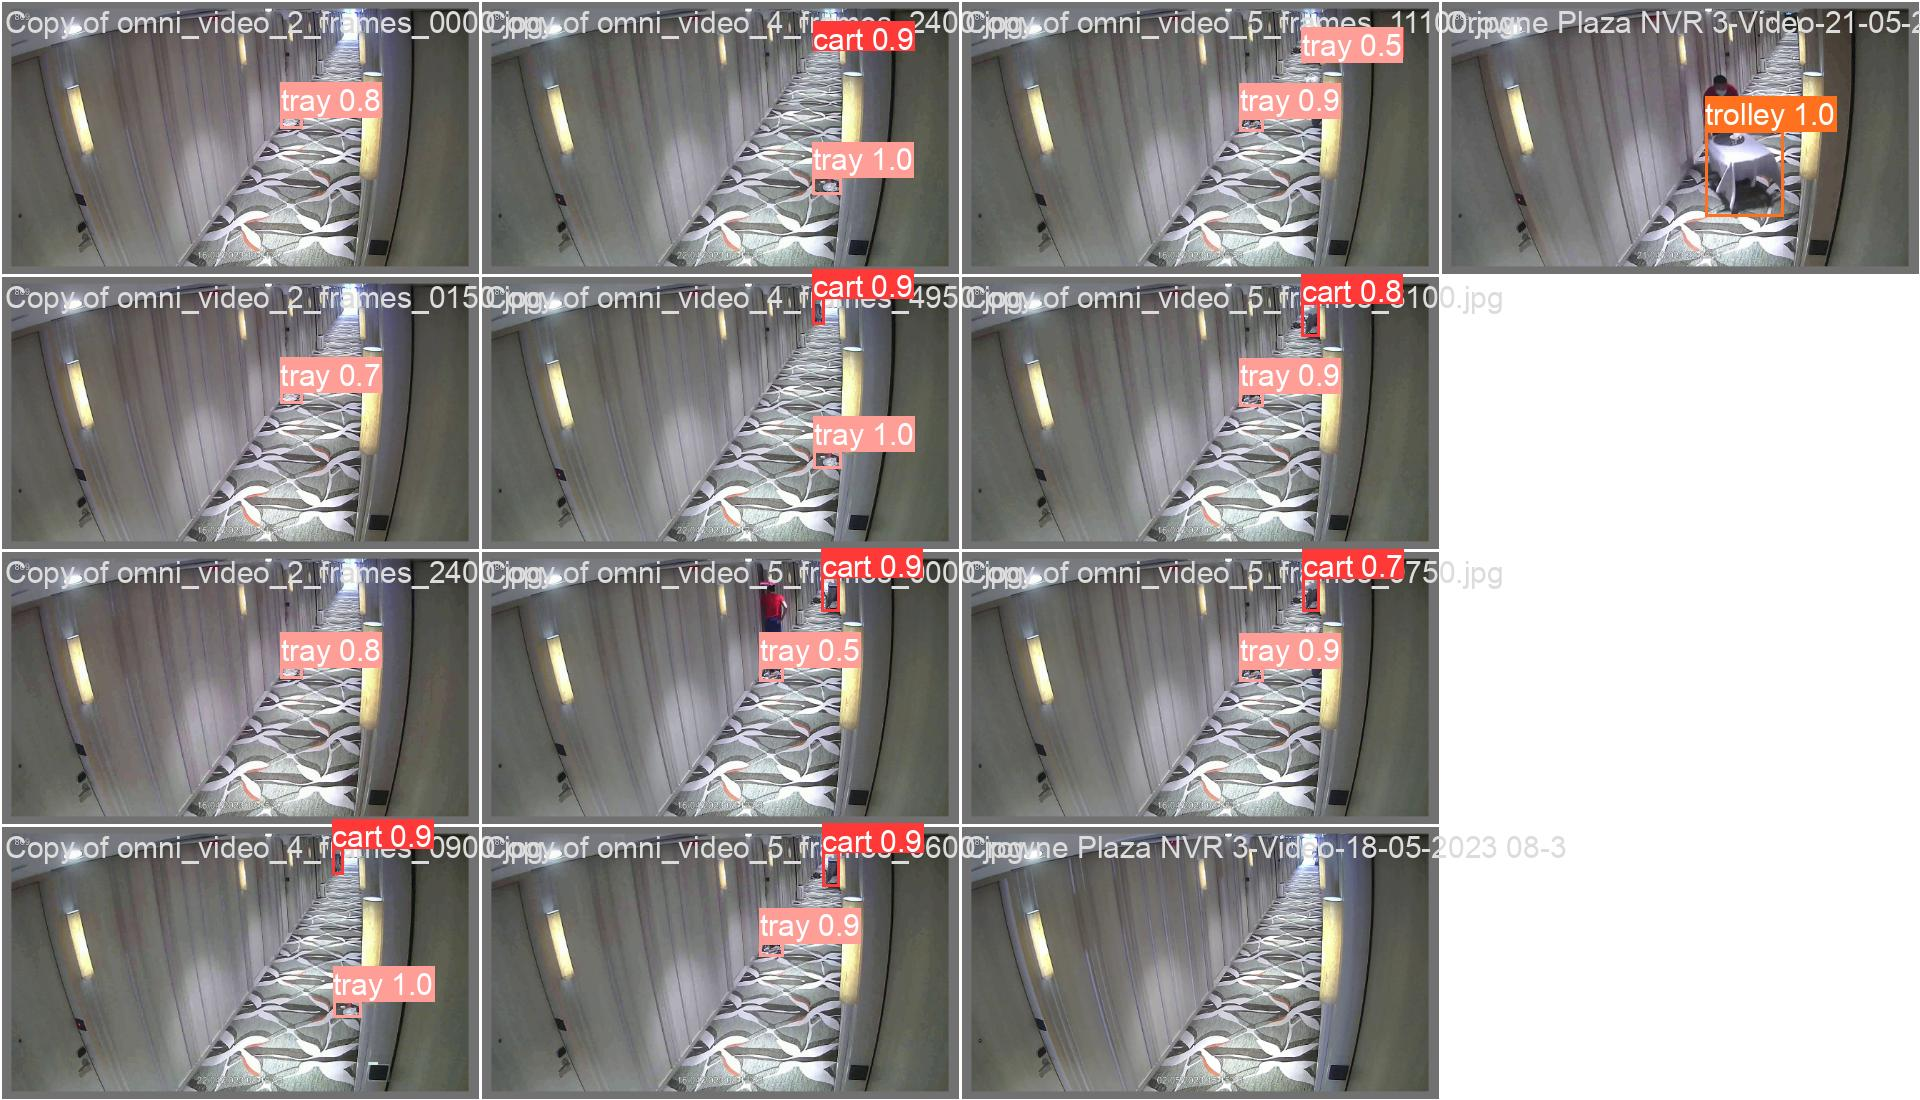

In [6]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/{run_name}/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [16]:
import os

In [ ]:
INPUT_VIDEO_PATH = f"{DATA_HOME}/video-processed/"
# OUTPUT_VIDEO_PATH = f"{DATA_HOME}/output-{name}"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/{run_name}/weights/best.pt"

# output path in /home/ubuntu/graymatics-detections-matt/crown-plaza/runs/detect/train
!yolo predict model="{TRAINED_MODEL_PATH}" source="{INPUT_VIDEO_PATH}" conf=0.8


In [14]:
!tar -czvf predictions.zip -C "/home/ubuntu/graymatics-detections-matt/crown-plaza/runs/detect/predict4" .

./
./Copy of omni_video_2.mp4


./Copy of omni_video_4.mp4
./Copy of omni_video_5.mp4
